# Baseline System

### Load the Behaviors Data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

behaviors_path = './MINDsmall_train/behaviors.tsv'

behaviors_data = pd.read_csv(behaviors_path, sep='\t', header=None, usecols=[3], names=['interactions'])

print(behaviors_data.head())


                                        interactions
0  N55189 N42782 N34694 N45794 N18445 N63302 N104...
1  N31739 N6072 N63045 N23979 N35656 N43353 N8129...
2  N10732 N25792 N7563 N21087 N41087 N5445 N60384...
3  N45729 N2203 N871 N53880 N41375 N43142 N33013 ...
4                        N10078 N56514 N14904 N33740


### Count Article Interactions

In [3]:
# Splitting the interactions into individual article IDs and counting them
article_interactions = behaviors_data['interactions'].str.split(expand=True).stack().value_counts().reset_index()
article_interactions.columns = ['ArticleID', 'InteractionCount']

# Verify that interactions are processed
print(article_interactions.head())



  ArticleID  InteractionCount
0      N306             20765
1    N42620             17918
2    N31801             15694
3    N47020             15216
4    N45794             15200


### Identify the Most Popular Articles

  ArticleID  InteractionCount
0      N306             20765
1    N42620             17918
2    N31801             15694
3    N47020             15216
4    N45794             15200
5    N43142             14565
6      N871             14210
7    N55189             13394
8    N29177             13243
9    N16715             13011


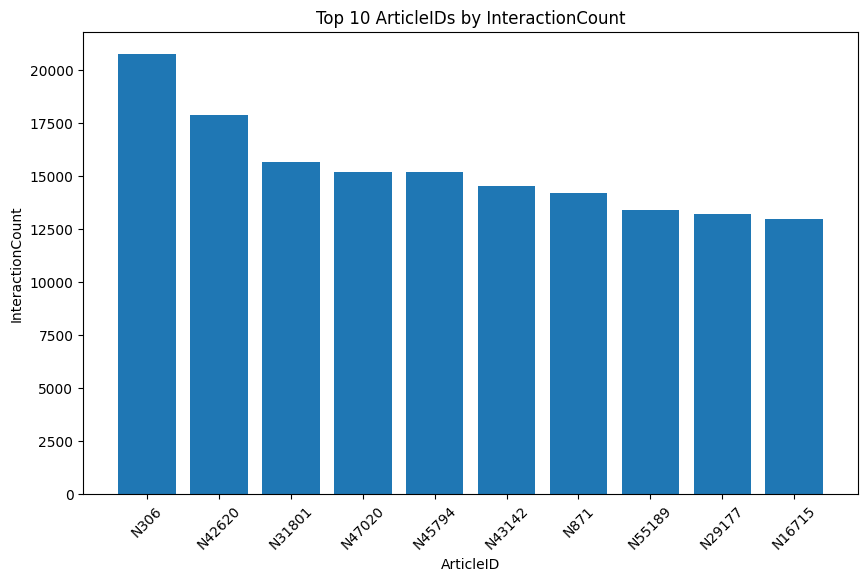

In [4]:
# Selecting the top N most popular articles
N = 10
top_articles = article_interactions.head(N)
print(top_articles)


# Get the top 10 articles by InteractionCount
top_10_articles = article_interactions.nlargest(10, 'InteractionCount')

# Plot the data
plt.figure(figsize=(10, 6))
plt.bar(top_10_articles['ArticleID'], top_10_articles['InteractionCount'])
plt.xlabel('ArticleID')
plt.ylabel('InteractionCount')
plt.title('Top 10 ArticleIDs by InteractionCount')
plt.xticks(rotation=45)
plt.show()

# Temporal pattern analysis

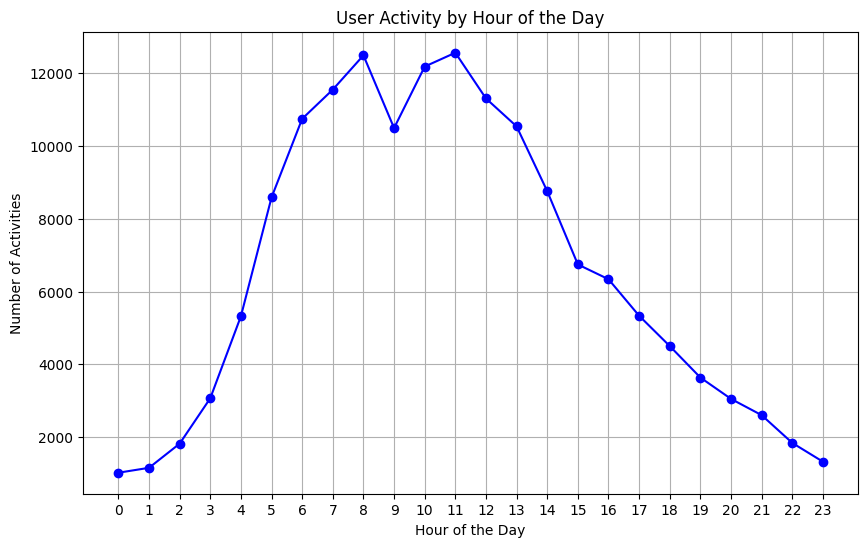

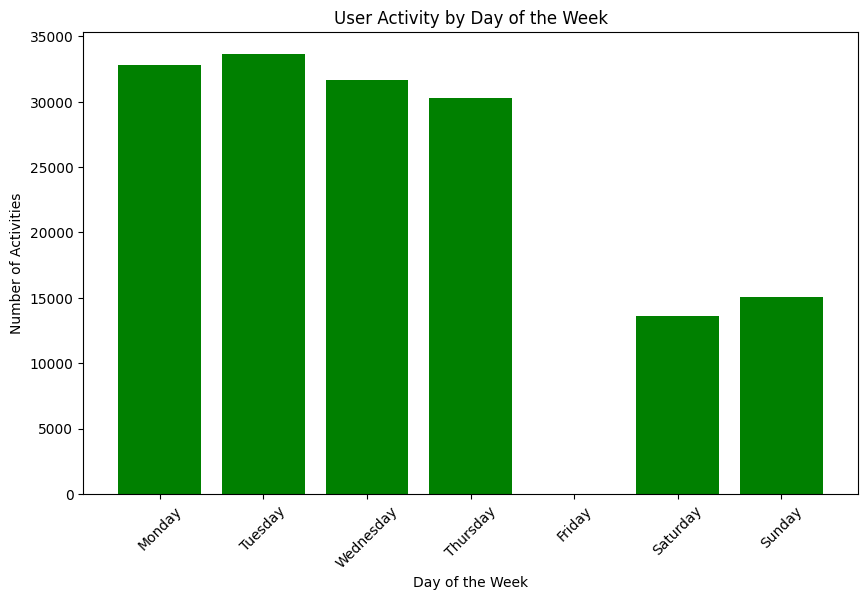

'Temporal pattern analysis plotted successfully.'

In [5]:
# Load the dataset
behaviors_data = pd.read_csv('./MINDsmall_train/behaviors.tsv', delimiter='\t', header=None)

# Checks and preparing the data for temporal pattern analysis

try:
    # Ensuring the timestamp is correctly formatted as datetime
    behaviors_data[2] = pd.to_datetime(behaviors_data[2])

    # Extracting hour and day of week for analysis
    behaviors_data['Hour'] = behaviors_data[2].dt.hour
    behaviors_data['DayOfWeek'] = behaviors_data[2].dt.day_name()

    # Aggregating counts by hour and by day of the week
    hourly_activity = behaviors_data['Hour'].value_counts().sort_index()
    daily_activity = behaviors_data['DayOfWeek'].value_counts()

    # Plotting hourly activity
    plt.figure(figsize=(10, 6))
    plt.plot(hourly_activity.index, hourly_activity.values, marker='o', linestyle='-', color='blue')
    plt.title('User Activity by Hour of the Day')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Activities')
    plt.grid(True)
    plt.xticks(hourly_activity.index)  
    plt.show()

    # Plotting daily activity
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_activity = daily_activity.reindex(days_order)  

    plt.figure(figsize=(10, 6))
    plt.bar(daily_activity.index, daily_activity.values, color='green')
    plt.title('User Activity by Day of the Week')
    plt.xlabel('Day of the Week')
    plt.ylabel('Number of Activities')
    plt.xticks(rotation=45)
    plt.show()
except Exception as e:
    temporal_error = str(e)

temporal_error if 'temporal_error' in locals() else "Temporal pattern analysis plotted successfully."


# Normalizing the date using MixMax Scaler

In [28]:
from sklearn.preprocessing import MinMaxScaler

# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Normalize the article view counts
normalized_counts = scaler.fit_transform(article_interactions['InteractionCount'].values.reshape(-1, 1))

# Update the article_interactions DataFrame with the normalized counts
article_interactions['NormalizedCount'] = normalized_counts

# Display the updated DataFrame
print(article_interactions.head())

  ArticleID  InteractionCount  NormalizedCount
0      N306             20765         1.000000
1    N42620             17918         0.862888
2    N31801             15694         0.755779
3    N47020             15216         0.732759
4    N45794             15200         0.731988


### Loading the Articles Data

In [6]:

news_path = 'MINDsmall_train/news.tsv'

# Load the news data, focusing on relevant columns
news_data = pd.read_csv(news_path, sep='\t', header=None, names=['ArticleID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Entities', 'Relationships'])


### Matching Top Articles with Their Details

In [7]:
# Merging top_articles with news_data to fetch article details
recommendations = pd.merge(top_articles, news_data[['ArticleID', 'Title', 'URL']], on='ArticleID', how='left')


### Presenting Recommendations to Users

In [8]:
# Display the recommendations
print("Top N Article Recommendations:")
for index, row in recommendations.iterrows():
    print(f"{index+1}: {row['Title']} ({row['URL']})")


Top N Article Recommendations:
1: Kevin Spacey Won't Be Charged in Sexual Assault Case After Accuser Dies (https://assets.msn.com/labs/mind/AAJy6rv.html)
2: Heidi Klum's 2019 Halloween Costume Transformation Is Mind-Blowing   But, Like, What Is It? (https://assets.msn.com/labs/mind/AAJFlhi.html)
3: Joe Biden reportedly denied Communion at a South Carolina church because of his stance on abortion (https://assets.msn.com/labs/mind/AAJwml6.html)
4: The News In Cartoons (https://assets.msn.com/labs/mind/AAJ7oYd.html)
5: Four flight attendants were arrested in Miami's airport after bringing in thousands in cash, police say (https://assets.msn.com/labs/mind/AAJcQKF.html)
6: Former NBA first-round pick Jim Farmer arrested in sex sting operation (https://assets.msn.com/labs/mind/AAJBmut.html)
7: Woman, suspect dead at 'Tarzan' actor Ron Ely's California residence (https://assets.msn.com/labs/mind/AAIRnqy.html)
8: 'Wheel Of Fortune' Guest Delivers Hilarious, Off The Rails Introduction (https://

## Content-Based Filtering

### Extract Features Using TF-IDF

In [9]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd
import numpy as np

news_path = 'MINDsmall_train/news.tsv'
news_data = pd.read_csv(news_path, sep='\t', header=None, names=['ArticleID', 'Category', 'SubCategory', 'Title', 'Abstract', 'URL', 'Entities', 'Relationships'])

news_data['Title'] = news_data['Title'].fillna('')
news_data['Abstract'] = news_data['Abstract'].fillna('')

# Concatenating title and abstract for a comprehensive representation
news_data['content'] = news_data['Title'] + " " + news_data['Abstract']

# Vectorizing the content using TF-IDF
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=10)

tfidf_matrix = tfidf_vectorizer.fit_transform(news_data['content'])


### Loading Entity Embeddings

In [10]:
def load_entity_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            values = line.split()
            entity_id = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings[entity_id] = vector
    return embeddings


entity_embeddings_path = './MINDsmall_train/entity_embedding.vec'
entity_embeddings = load_entity_embeddings(entity_embeddings_path)


### Prepare Article Entity Embeddings

In [11]:
def article_to_embedding(article_entities, entity_embeddings):
    
    entities = article_entities.split()
    embeddings = [entity_embeddings[entity] for entity in entities if entity in entity_embeddings]
    
    if embeddings:
        article_embedding = np.mean(embeddings, axis=0)
    else:
        article_embedding = np.zeros(next(iter(entity_embeddings.values())).shape)
    return article_embedding

article_embeddings = np.array([article_to_embedding(entities, entity_embeddings) for entities in news_data['Entities'].fillna('')])


### Combine TF-IDF and Entity Embeddings

In [12]:
from sklearn.preprocessing import normalize

# Normalize both matrices
tfidf_matrix_normalized = normalize(tfidf_matrix, axis=1)
article_embeddings_normalized = normalize(article_embeddings, axis=1)

# Combine TF-IDF and entity embeddings by concatenating them
combined_features = np.hstack([tfidf_matrix_normalized.toarray(), article_embeddings_normalized])


### Compute Similarity Scores

In [13]:
# Example user article interactions
user_interacted_articles = ['N55528', 'N61837']  

# Map article IDs to indices in the combined_features matrix
article_indices = [news_data[news_data['ArticleID'] == article_id].index[0] for article_id in user_interacted_articles if any(news_data['ArticleID'] == article_id)]

# Compute the user profile by averaging the vectors of the interacted articles
user_profile = np.mean(combined_features[article_indices, :], axis=0)


In [14]:
from sklearn.metrics.pairwise import cosine_similarity

# Reshape the user profile to fit the cosine_similarity function requirements
user_profile_reshaped = user_profile.reshape(1, -1)

# Compute similarity scores between the user profile and all article profiles
similarity_scores = cosine_similarity(user_profile_reshaped, combined_features).flatten()

# Get the indices of the articles, sorted by similarity (most similar first)
recommended_article_indices = similarity_scores.argsort()[::-1]


### Recommend Articles

In [15]:
# Number of articles to recommend
N = 5

# Filter out articles the user has already seen
recommendations_indices = [idx for idx in recommended_article_indices if idx not in article_indices][:N]

# Fetch the recommended articles
recommended_articles = news_data.iloc[recommendations_indices][['ArticleID', 'Title', 'URL']]

# Display recommendations
print("We recommend the following articles based on your interests:")
for index, article in recommended_articles.iterrows():
    print(f"{article['Title']} - {article['URL']}")


We recommend the following articles based on your interests:
Supreme Court takes up DACA - https://assets.msn.com/labs/mind/BBWHCZf.html
Bernie Sanders: 'The difference between Trump and me is he lies' - https://assets.msn.com/labs/mind/AAIIsIU.html
Adam Schiff's 'ham sandwich': Not an inquiry, just a show - https://assets.msn.com/labs/mind/BBWEe6C.html
Bannon says Stone was Trump campaign link to WikiLeaks - https://assets.msn.com/labs/mind/BBWtcWX.html
How to survive an impeachment - https://assets.msn.com/labs/mind/AAIIOLz.html


## Evaluation

### Uses metrics like Precision@k, Recall@k for accuracy.
### Considering A/B testing with real users for more holistic evaluation including engagement and satisfaction.

In [16]:
behaviors_df = pd.read_csv(behaviors_path, sep='\t', header=None, names=['ImpressionID', 'UserID', 'Time', 'History', 'Impressions'])

# Preview the DataFrame
print(behaviors_df.head())


   ImpressionID  UserID                   Time  \
0             1  U13740  11/11/2019 9:05:58 AM   
1             2  U91836  11/12/2019 6:11:30 PM   
2             3  U73700  11/14/2019 7:01:48 AM   
3             4  U34670  11/11/2019 5:28:05 AM   
4             5   U8125  11/12/2019 4:11:21 PM   

                                             History  \
0  N55189 N42782 N34694 N45794 N18445 N63302 N104...   
1  N31739 N6072 N63045 N23979 N35656 N43353 N8129...   
2  N10732 N25792 N7563 N21087 N41087 N5445 N60384...   
3  N45729 N2203 N871 N53880 N41375 N43142 N33013 ...   
4                        N10078 N56514 N14904 N33740   

                                         Impressions  
0                                  N55689-1 N35729-0  
1  N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...  
2  N50014-0 N23877-0 N35389-0 N49712-0 N16844-0 N...  
3                N35729-0 N33632-0 N49685-1 N27581-0  
4  N39985-0 N36050-0 N16096-0 N8400-1 N22407-0 N6...  


### Create a Synthetic DataFrame

In [17]:
# Initialize list to hold processed data
processed_data = []

# Iterate over each row in the behaviors DataFrame
for _, row in behaviors_df.iterrows():
    user_id = row['UserID']
    impressions = row['Impressions'].split(' ')  # Split the impressions into list
    for impression in impressions:
        item_id, interaction = impression.split('-')  # Split each impression into itemID and interactionFlag
        processed_data.append([user_id, item_id, int(interaction)])  # Assuming interactionFlag is binary (1 or 0)

# Create a new DataFrame with the processed data
df = pd.DataFrame(processed_data, columns=['userID', 'itemID', 'rating'])

print(df.head())


   userID  itemID  rating
0  U13740  N55689       1
1  U13740  N35729       0
2  U91836  N20678       0
3  U91836  N39317       0
4  U91836  N58114       0


### Load the Data into Surprise

In [18]:
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split

# Define the scale of the ratings
reader = Reader(rating_scale=(0, 1))

# Load the dataset into Surprise
data = Dataset.load_from_df(df[['userID', 'itemID', 'rating']], reader)

# Split the dataset for training and testing
trainset, testset = train_test_split(data, test_size=0.25)


### Train a Recommendation Model

In [19]:
# Use the SVD algorithm
model = SVD()

# Train the model
model.fit(trainset)


### Generate Predictions

In [20]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    """
    Return the top-N recommendation for each user from a set of predictions.
    
    Args:
    predictions(list of Prediction objects): The list of predictions, as returned by the test method of a Surprise model.
    n(int): The number of recommendation to output for each user. Defaults to 10.
    
    Returns:
    A dict where keys are user IDs and values are lists of tuples:
    [(item ID, estimated rating), ...] of size n.
    """
    
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for pred in predictions:
        top_n[pred.uid].append((pred.iid, pred.est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


In [21]:
# Generate predictions for the testset
# Test the model on the testset
predictions = model.test(testset)

# Get the top-10 recommendations for each user
top_n = get_top_n(predictions, n=10)

# Example: print the top-10 recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

U93943 ['N49685', 'N33619', 'N47061', 'N7319', 'N38779', 'N32866', 'N15194', 'N29839', 'N50060', 'N36789']
U59434 ['N12589', 'N56211', 'N3232', 'N43869', 'N47245', 'N18572', 'N17965', 'N58051']
U32105 ['N38779', 'N62360', 'N6837', 'N63154', 'N1539', 'N60105', 'N23814', 'N34668', 'N47602', 'N32544']
U28571 ['N55689', 'N58363', 'N52122', 'N35729', 'N35729', 'N23446', 'N12029', 'N38779', 'N38779', 'N18708']
U87148 ['N49685', 'N55689', 'N55689', 'N35729', 'N42977', 'N23446', 'N4642', 'N51048', 'N51048', 'N40109']
U88594 ['N55689', 'N55689', 'N51048', 'N26025', 'N56193', 'N38550', 'N62360', 'N62360', 'N59673', 'N48473']
U77182 ['N53585', 'N55689', 'N63970', 'N63970', 'N58363', 'N22061', 'N35815', 'N62360', 'N33203', 'N49180']
U43480 ['N35729', 'N35170', 'N43502', 'N12523', 'N35172', 'N6056', 'N43083', 'N28773', 'N52723', 'N60992']
U16841 ['N42457', 'N1539', 'N6926', 'N60550', 'N62360', 'N36789', 'N47412', 'N56517', 'N31978', 'N45523']
U1279 ['N33619', 'N42977', 'N47099', 'N29839', 'N26262',

### Calculate Precision@k and Recall@k

In [22]:
from collections import defaultdict

def precision_recall_at_k(predictions, k=10, threshold=0.5):
    """Calculate average precision and recall at k for each user."""
    user_est_true = defaultdict(list)
    
    for pred in predictions:
        uid, true_r, est = pred.uid, pred.r_ui, pred.est
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold)) for (est, true_r) in user_ratings[:k])

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls



In [23]:
def precision_recall_at_k(top_n, true_interactions, k=10, threshold=0.5):
    """
    Calculate precision and recall at k metrics for each user.
    
    Args:
    top_n (dict): A dictionary where keys are user IDs and values are lists of tuples (item ID, estimated rating).
    true_interactions (dict): A dictionary where keys are user IDs and values are sets of item IDs that the user has interacted with.
    k (int): The number of top recommendations to consider for calculating precision and recall.
    threshold (float): The rating threshold for considering a recommendation as 'relevant'.
    
    Returns:
    precisions (dict): A dictionary where keys are user IDs and values are the precision for the corresponding user.
    recalls (dict): A dictionary where keys are user IDs and values are the recall for the corresponding user.
    """
    
    precisions = dict()
    recalls = dict()

    for uid, user_ratings in top_n.items():
        # Convert top-n recommendations to a set of item IDs
        top_n_items = set([iid for (iid, rating) in user_ratings if rating >= threshold])
        
        # Get the set of true interactions for the user
        true_items = true_interactions.get(uid, set())
        
        # Calculate precision and recall
        n_rel = len(true_items)
        n_rec_k = len(top_n_items)
        n_rel_and_rec_k = len(top_n_items.intersection(true_items))
        
        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0
        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls


In [24]:
# Get top-N recommendations for each user
top_n = get_top_n(predictions, n=10)

true_interactions = defaultdict(set)
for uid, iid, _ in testset:
    true_interactions[uid].add(iid)

# Calculate precision and recall at k
precisions, recalls = precision_recall_at_k(top_n, true_interactions, k=10, threshold=0.5)

# Calculate average precision and recall at k
avg_precision = sum(precisions.values()) / len(precisions)
avg_recall = sum(recalls.values()) / len(recalls)
print(f'Average Precision@K: {avg_precision:.4f}, Average Recall@K: {avg_recall:.4f}')


Average Precision@K: 0.1882, Average Recall@K: 0.0207


## A/B Testing

### Hypothesis: "Implementing a collaborative filtering model will increase user engagement by 10% compared to the current content-based filtering model."

### Simulating User Data for A/B Testing

In [25]:
import pandas as pd
import numpy as np

# Simulating a DataFrame with user IDs
user_ids = ['U' + str(i) for i in range(1, 101)]  # Simulating 100 users, U1 through U100
users_df = pd.DataFrame({'userID': user_ids})

# Display the first few rows of the DataFrame
print(users_df.head())

# Randomly sample half of the users for each group
group_a = users_df.sample(frac=0.5, random_state=42)
group_b = users_df.drop(group_a.index)


  userID
0     U1
1     U2
2     U3
3     U4
4     U5


### Segmenting Users into Groups for A/B Testing

In [26]:
# Randomly sample half of the users for Group A
group_a = users_df.sample(frac=0.5, random_state=42)

# The rest of the users form Group B
group_b = users_df.drop(group_a.index)

# Display the size of each group
print(f"Group A: {len(group_a)} users")
print(f"Group B: {len(group_b)} users")


Group A: 50 users
Group B: 50 users
